# Mouse in vitro thyroid scRNA-seq analysis - Romitti et al 2021
   
 *16-04-2021*
 
 *Sema Elif Eski*

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvelo as scv
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.external as sce


In [3]:
sc.settings.verbosity = 2             
sc.settings.set_figure_params(dpi=80)
sc.logging.print_header()  

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [4]:
cmap1=mpl.cm.OrRd(np.linspace(0,1,20))
cmap1= mpl.colors.ListedColormap(cmap1[3:,:-1])

# Clustering analysis - Scanpy

## Load the data

In [5]:
adata = sc.read_10x_mtx(
    '/home/zebrafish/Elif/Singhlab/SC-Data/Mouse_BFX1208/filtered_feature_bc_matrix/',  
    var_names='gene_symbols',                  
    cache=True) 

... reading from cache file cache/home-zebrafish-Elif-Singhlab-SC-Data-Mouse_BFX1208-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata

AnnData object with n_obs × n_vars = 9904 × 30307
    var: 'gene_ids'

Load cell cycle genes defined in Tirosh et al, 2015

In [7]:
cell_cycle_genes = [x.strip() for x in open('/home/zebrafish/Elif/Singhlab/SC-Data/BioMaRt/cell_cycle_genes_mm.txt')]

s_genes = cell_cycle_genes[:41]
g2m_genes = cell_cycle_genes[41:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

## Preprocessing

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 11671 genes that are detected in less than 3 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 9904 × 18636
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

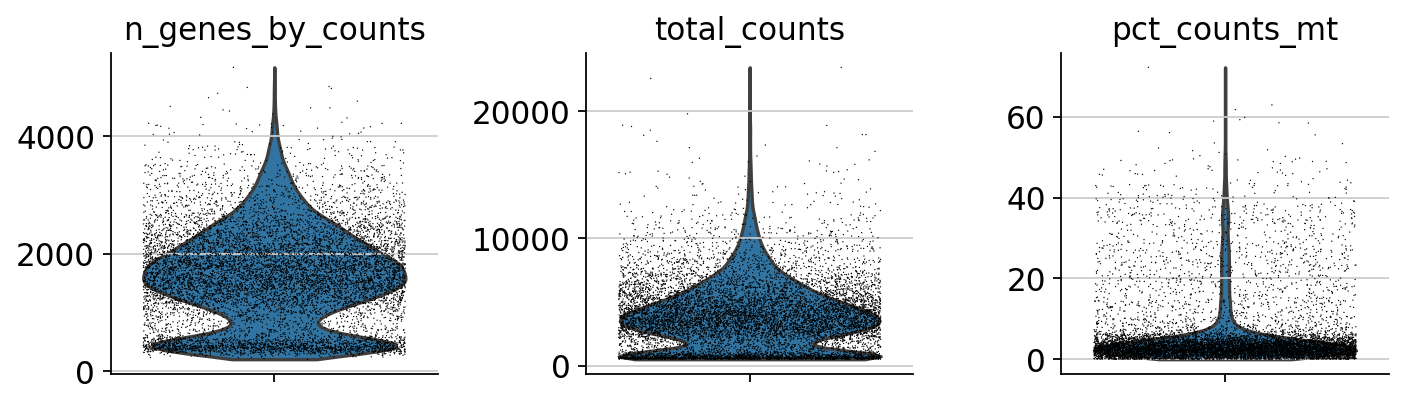

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size= 0.6)

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.n_genes_by_counts > 800, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 15000, :]
adata = adata[adata.obs.total_counts >2000, :]

### after filtration:

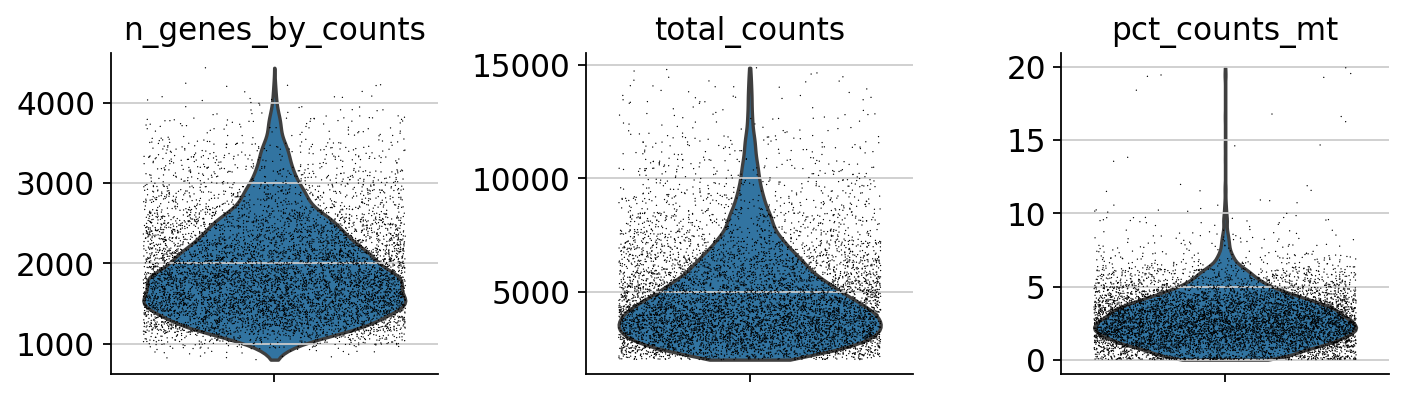

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, size= 0.6)

In [14]:
adata

View of AnnData object with n_obs × n_vars = 7381 × 18636
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Quality control statistics

In [15]:
d= {"mean": [adata.obs["n_genes"].mean(), adata.obs["total_counts"].mean(), adata.obs["pct_counts_mt"].mean()],
    "median": [adata.obs["n_genes"].median(), adata.obs["total_counts"].median(), adata.obs["pct_counts_mt"].median()],
    "std": [adata.obs["n_genes"].std(), adata.obs["total_counts"].std(), adata.obs["pct_counts_mt"].std()]}

qc_stats = pd.DataFrame(data= d, index = ["# of genes", "# of UMI","% of mito"])
qc_stats

,mean,median,std
# of genes,1941.129386,1834.000000,602.005877
# of UMI,4865.447266,4334.000000,2158.360352
% of mito,2.833719,2.610778,1.838156


In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=1.2, max_disp=8)

normalizing counts per cell
    finished (0:00:00)
calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00)
computing score 'G2M_score'
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)


In [17]:
adata.raw = adata

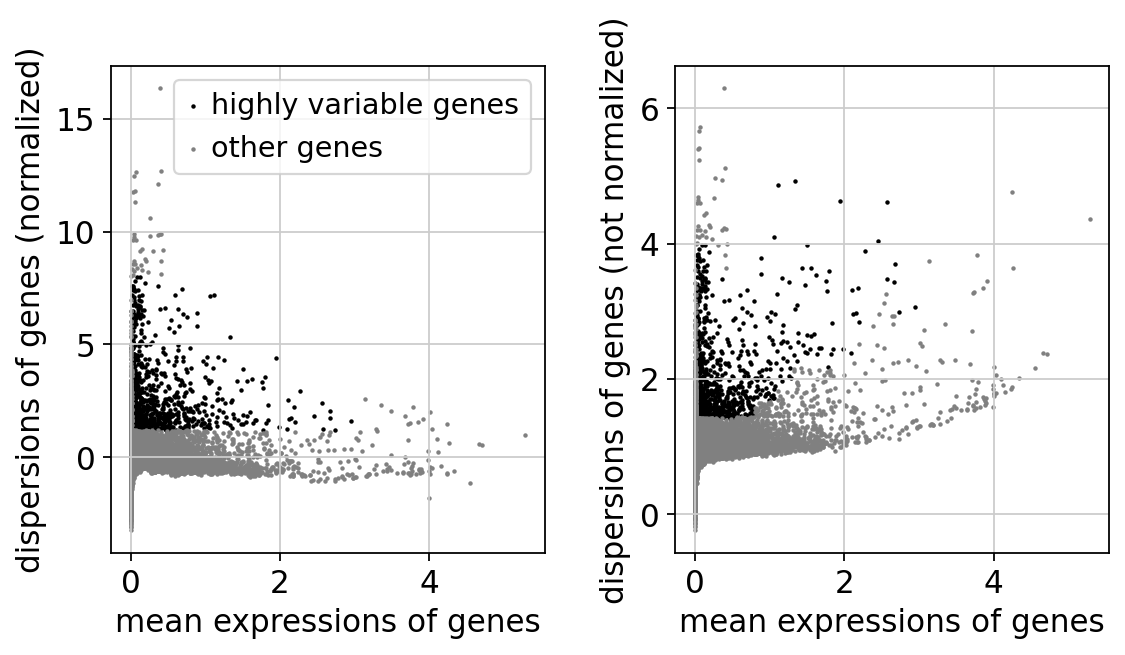

In [18]:
sc.pl.highly_variable_genes(adata)

### cell cycle regression

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt','S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


... storing 'phase' as categorical


    finished (0:03:15)


## Principal component analysis

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


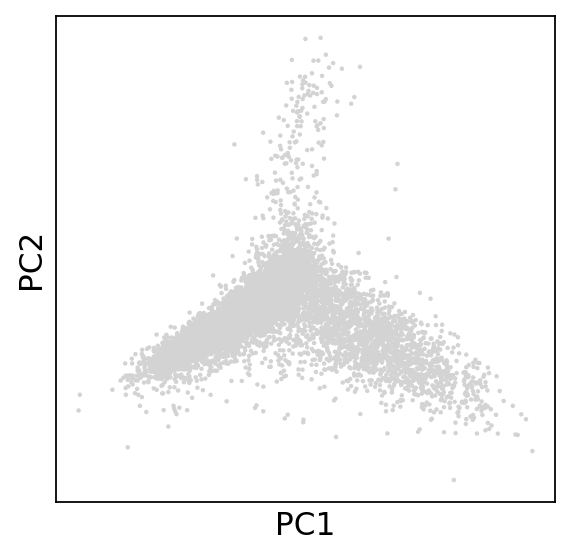

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

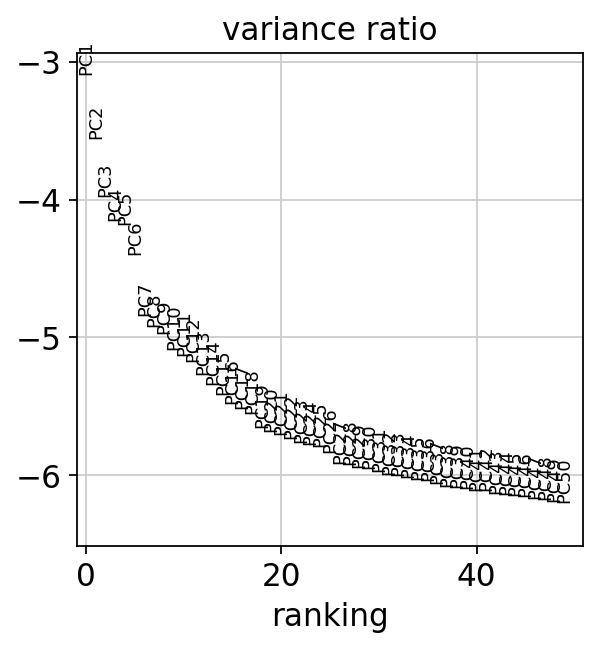

In [21]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

## Computing and embedding the neighborhood graph

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:02)
computing UMAP
    finished (0:00:06)
running Leiden clustering
    finished (0:00:00)


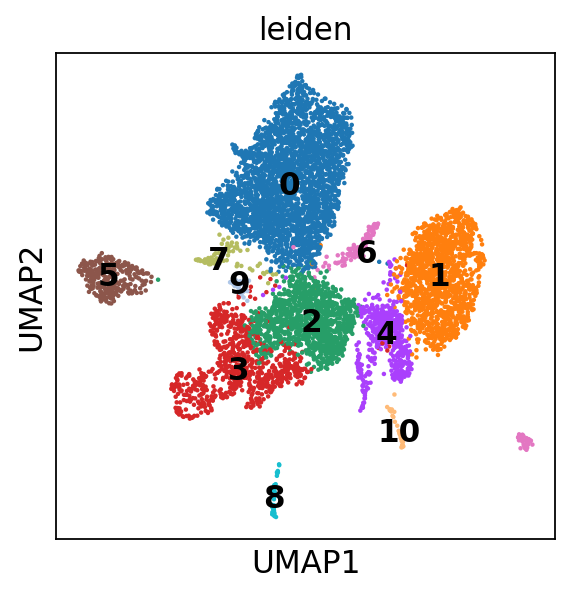

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.4)
sc.pl.umap(adata, color ="leiden", legend_loc = "on data")

#### Figure 2C-D-E

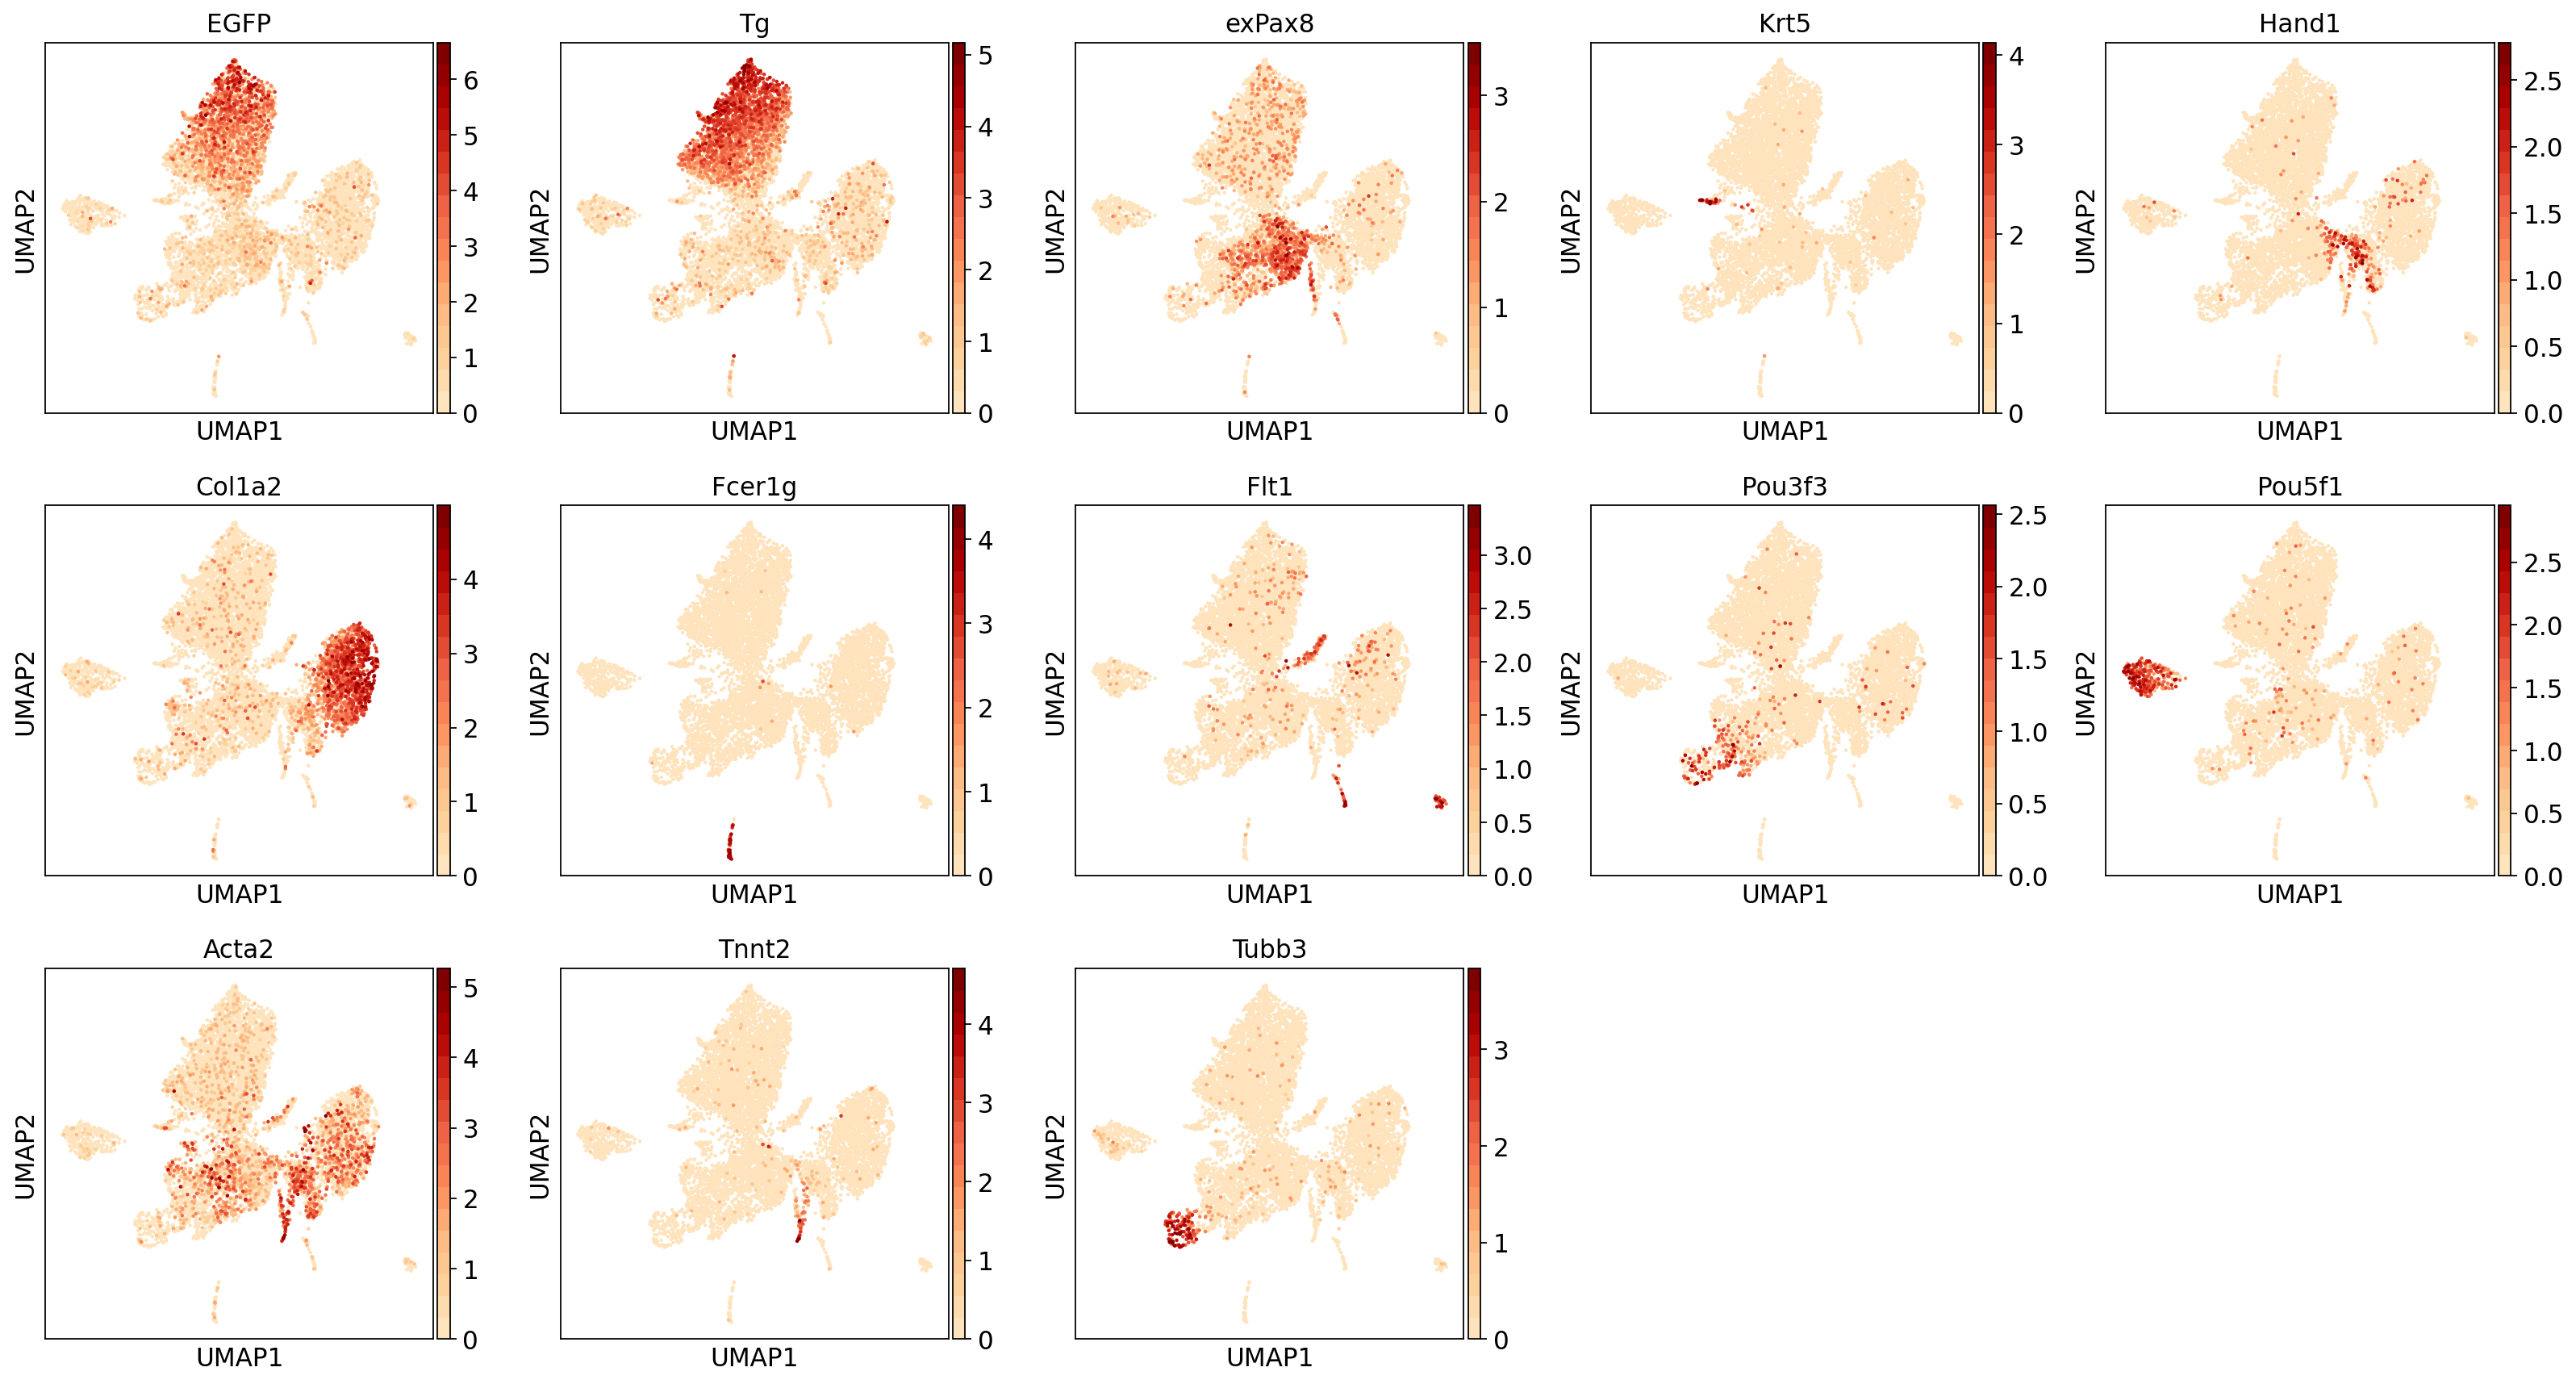

In [23]:
figure2 = ["EGFP","Tg","exPax8","Krt5","Hand1","Col1a2","Fcer1g","Flt1","Pou3f3","Pou5f1","Acta2","Tnnt2","Tubb3"]
sc.pl.umap(adata, color= figure2, cmap = cmap1, ncols = 5)

#### Figure 3C

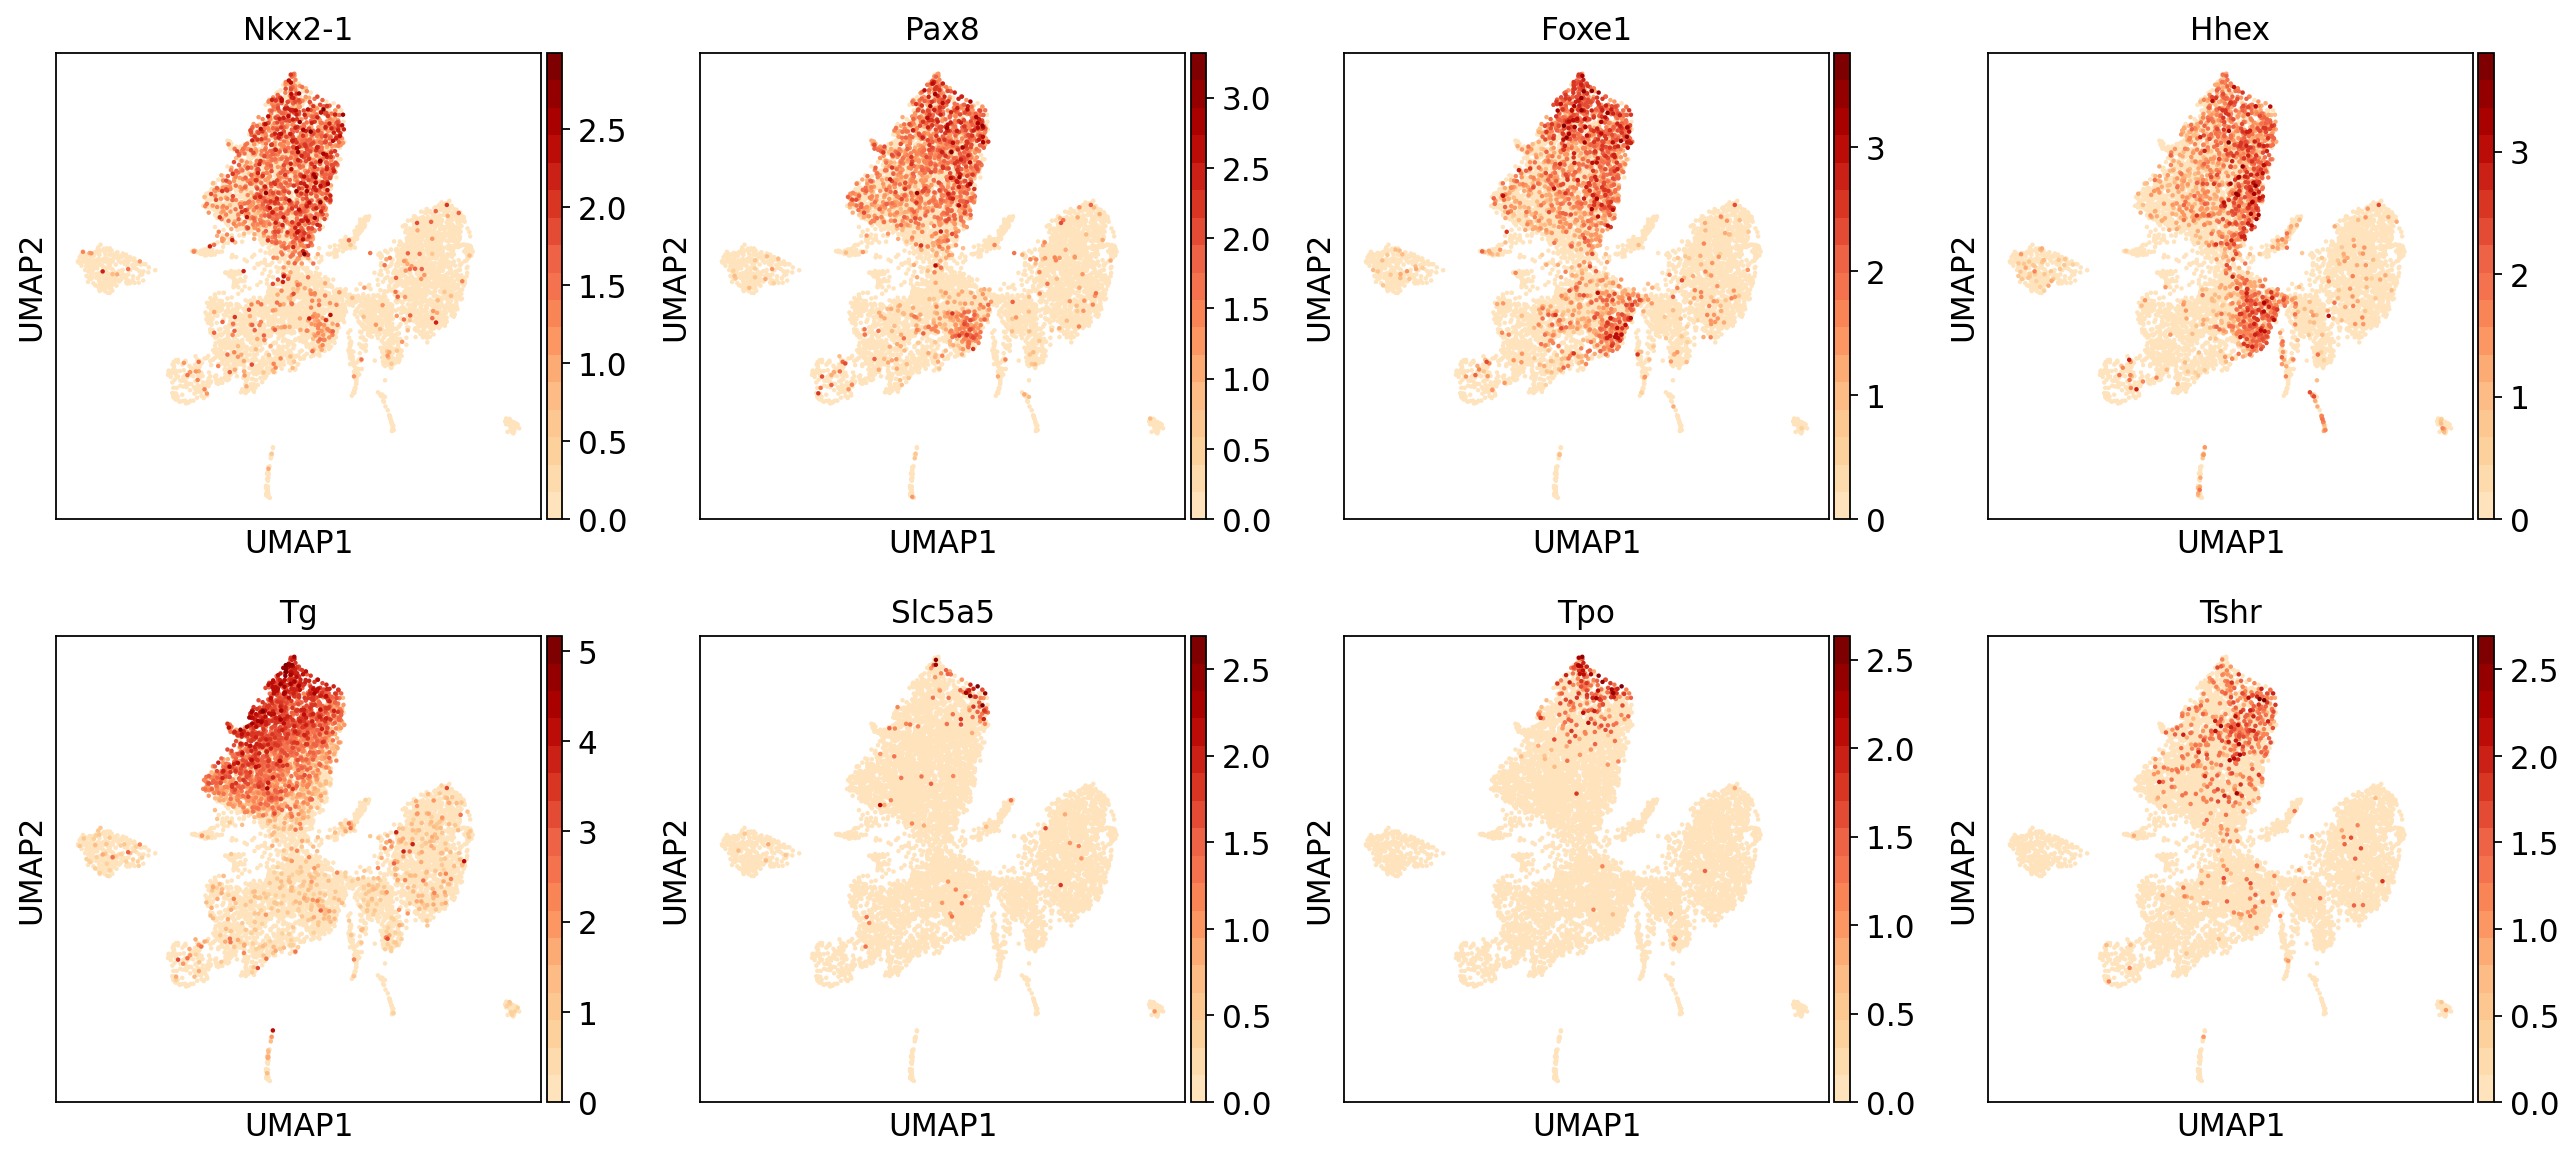

In [24]:
figure3 = ["Nkx2-1","Pax8","Foxe1","Hhex","Tg","Slc5a5","Tpo","Tshr"]
sc.pl.umap(adata, color= figure3, cmap = cmap1, ncols= 4)

#### Figure 4A

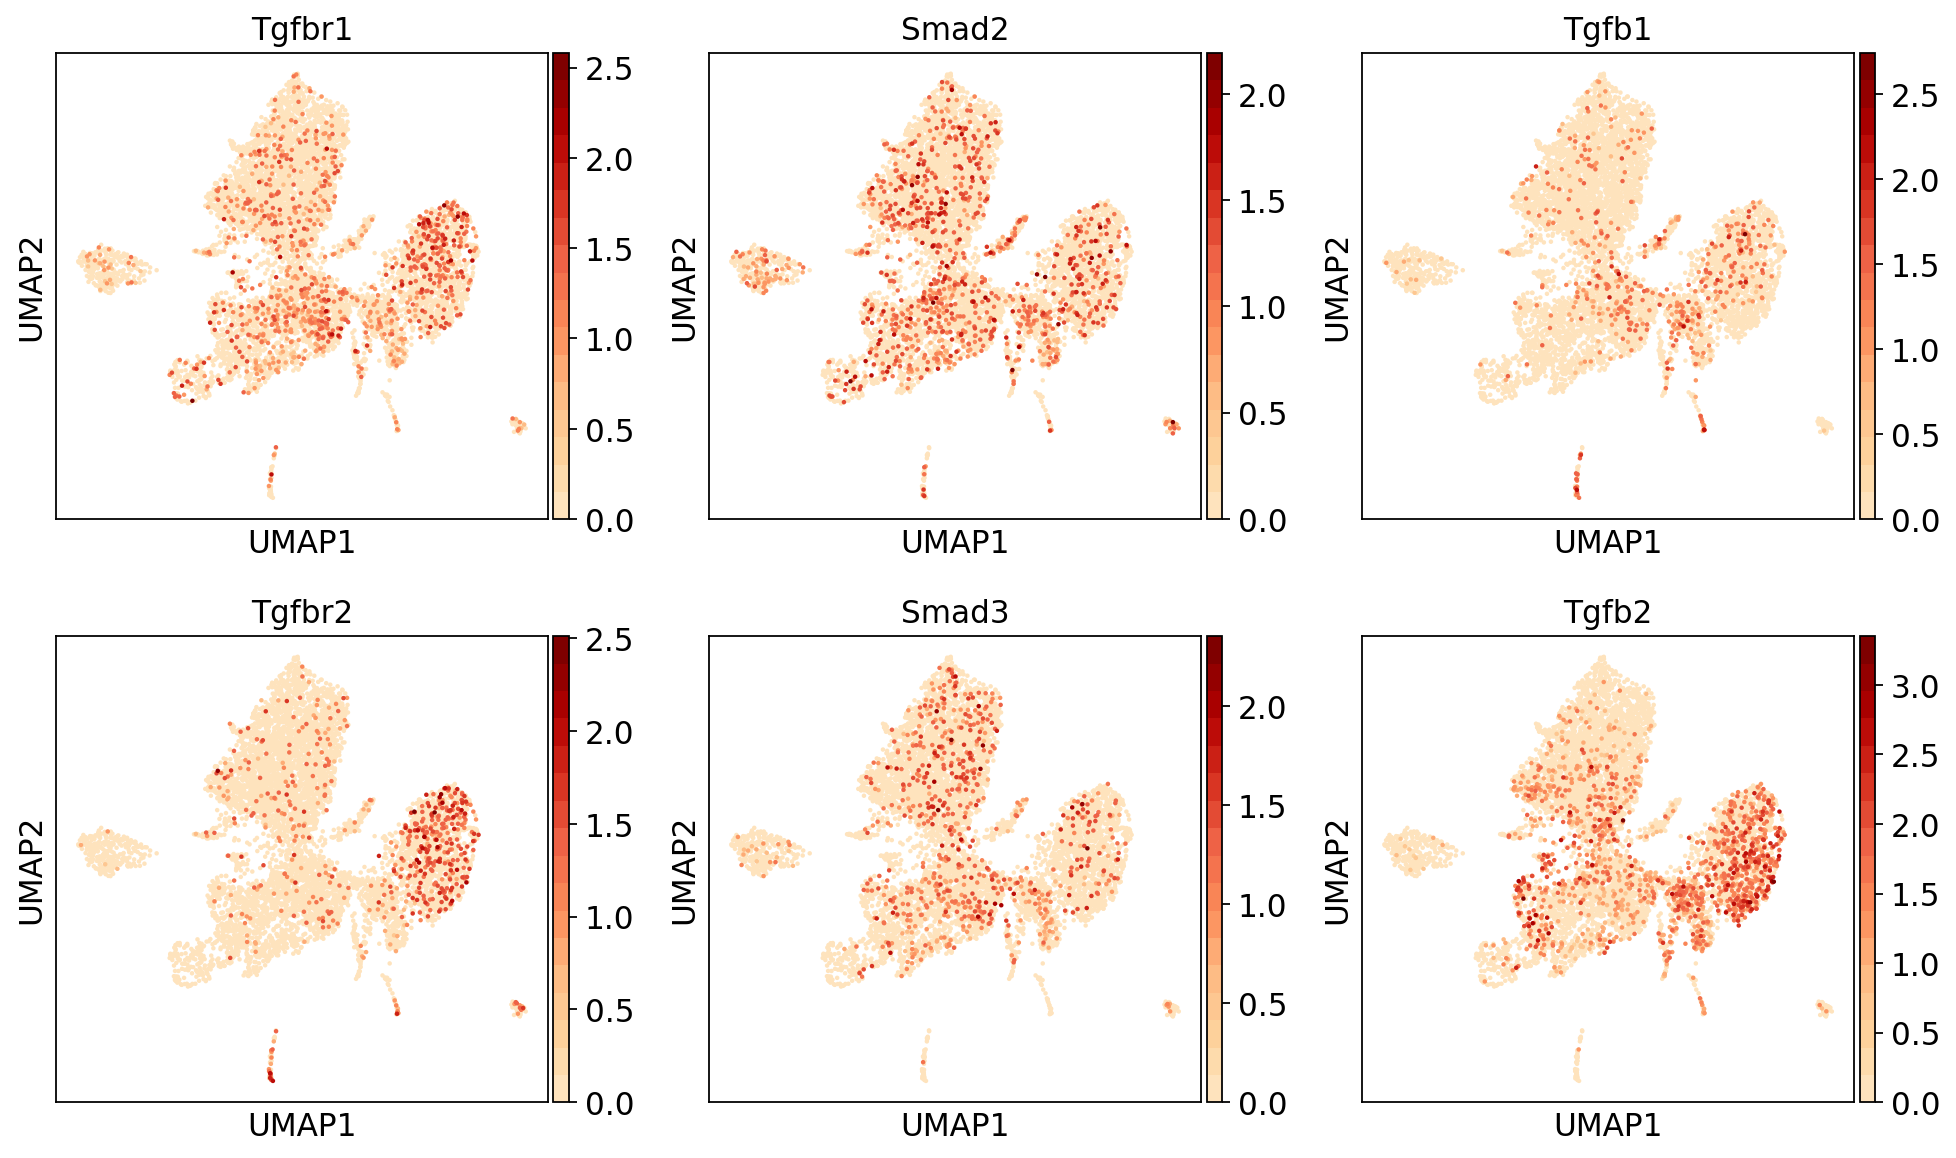

In [25]:
figure4 = ["Tgfbr1", "Smad2", "Tgfb1","Tgfbr2","Smad3","Tgfb2"]
sc.pl.umap(adata, color= figure4, cmap = cmap1, ncols= 3)

## Finding marker genes

In [26]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

ranking genes
    finished (0:00:06)


,0,1,2,3,4,5,6,7,8,9,10
0,Bsg,Col3a1,Hmga2,Sox11,Peg3,Dppa5a,Rbbp7,S100a14,Tyrobp,Dct,Cdh5
1,Klf6,Col1a1,Mdk,Tubb2b,Mdk,Mkrn1,Rbp4,S100a11,Tmsb4x,Pmel,Ecscr
2,Ndufa4l2,Col1a2,Id1,Map1b,Twist1,Hsp90aa1,Col4a1,Tacstd2,Fcer1g,Apoe,Kdr
3,Tg,Dcn,Hsp90ab1,Tubb5,Npm1,Pou5f1,Bex1,Klf5,Laptm5,Vim,Tagln2
4,Ubc,Lgals1,exPax8,Stmn1,Acta2,Trap1a,Flt1,Perp,Srgn,Ctsd,Flt1
5,Eif1,Bgn,Id3,Ckb,Bambi,Gpx4,Spink1,Epcam,B2m,Glul,Egfl7
6,Gapdh,Vim,Sox11,Marcks,Slc38a4,Sox2,Bex4,Krt7,C1qb,Gpnmb,Ctla2a
7,Mt1,Igfbp4,Nt5dc2,Tuba1a,Igf2r,Pmm1,Slc2a3,S100a10,Ccl3,Slc2a1,Ramp2
8,Jun,Ifitm3,H3f3b,Ttc3,Gpc3,Fabp3,Glul,Sat1,Cd14,Laptm4a,Col4a1
9,Fth1,Col6a1,Greb1,Psip1,Marcks,Klf2,Apoe,Hspb1,Ctsz,Six3,Plvap


In [27]:
for i in range(max(set([int(x) for x in adata.obs['leiden']])) + 1):
    i = str(i)
    df = sc.get.rank_genes_groups_df(adata, group= i, key="rank_genes_groups", pval_cutoff=0.05, log2fc_min=1.5, log2fc_max=None)
    export_csv =df.to_csv(f"/leidenDEG/LeidenDEG_Cluster_{i}.csv", index = None, header=True)

FileNotFoundError: [Errno 2] No such file or directory: '/leidenDEG/LeidenDEG_Cluster_0.csv'

## Annotation of the clusters

In [ ]:
old_to_new = {'0': 'Thyrocytes',
             '1': 'Fibroblasts',
             '2': 'Dox-responsive cluster',
             '3': 'Neuronal-like cells',
             '4': 'Mesoderm',
             '5': 'ES cells',
             '6': 'Endothelial',
             '7': 'Non-thyroid epithelial',
             '8': 'Immune cells',
             '9': 'Neuronal-like cells',
             '10': 'Endothelial'}
adata.obs['cells'] = adata.obs['leiden'].map(lambda x: old_to_new[x]).astype('category')

adata.uns["cells_colors"] = ['#2ca02c','#1f77b4','#ff7f0e','#d62728','#8c564b','#e377c2','#bcbd22','#7f7f7f','#17becf']

#### Figure 2A

In [ ]:
sc.pl.umap(adata, color = "cells")

In [ ]:
sc.tl.rank_genes_groups(adata, 'cells', method='wilcoxon')

for i in set(adata.obs['cells']):
    df = sc.get.rank_genes_groups_df(adata, group = i, key="rank_genes_groups", pval_cutoff=0.05, log2fc_min=1.5, log2fc_max=None)
    export_csv =df.to_csv(f"DEG_{i}.csv", index = None, header=True)

#### Number of each cell type in dataset:

In [ ]:
for i in set(adata.obs["cells"]):
    print(i)
    print(len([z for z,y in adata.obs["cells"].items() if y==i]))

 #### Figure 2B

In [ ]:
marker_genes_dict = {'ES cells': ['Pou5f1', 'Nanog','Sox2'],
                     'Dox-responsive cluster': ["exPax8", 'Foxe1', 'Hhex'],
                     'Thyrocytes': ['EGFP', 'Tg',"Nkx2-1", 'Pax8'],
                     'Non-thyroid epithelial': ['Krt5', 'Perp'],
                     'Neuronal-like cells': ["Pou3f3","Pax6","Tubb3"],
                     'Mesoderm': ['Hand1', 'Acta2'],
                     'Fibroblasts': ['Col1a2', 'Dcn'],
                     'Endothelial': ['Flt1', 'Kdr'],
                     'Immune cells': ['Tyrobp', 'Fcer1g']}

sc.pl.matrixplot(adata, marker_genes_dict, 'cells', dendrogram=False, standard_scale = 'var', cmap= 'OrRd', categories_order = ['ES cells','Dox-responsive cluster',
              'Thyrocytes','Non-thyroid epithelial','Neuronal-like cells','Mesoderm','Fibroblasts','Endothelial','Immune cells'], colorbar_title = "Mean \nExpression")

In [ ]:
results_file = "analysis_github.h5ad"
adata.write(results_file)

In [ ]:
annot= sc.get.obs_df(adata, keys= ["leiden","cells"], obsm_keys= [("X_pca", 0), ("X_pca", 1),("X_umap", 0), ("X_umap", 1)])
pd.DataFrame(data = annot).to_csv("metadata.csv")

After here, I switched to Seurat and select thyrocyte lineage as below:

## after selecting mature, immature and dox-responsive cluster in Seurat

In [ ]:
cluster = pd.read_csv('/home/zebrafish/Elif/Singhlab/SC-Data/Mouse_BFX1208/analysis/seurat/cc_regressed/Mature_immature_early_thyrocytes.csv', index_col = 0)

In [ ]:
adata.obs['cluster'] = cluster['cluster']

In [ ]:
adata.uns['cluster_colors'] = ['#9bb4e2','#5e87d0','#0b2b81','#d17e36','#d8d8d8']

In [ ]:
sc.pl.umap(adata, color=['cluster'], legend_loc="right margin", legend_fontsize =7, legend_fontoutline=1, frameon=False)





Save metadata into single file

In [ ]:
annot= sc.get.obs_df(adata, keys= ["leiden","cells","cluster"], obsm_keys= [("X_pca", 0), ("X_pca", 1),("X_umap", 0), ("X_umap", 1)])
pd.DataFrame(data = annot).to_csv("metadata.csv")

#### Figure 3B

In [ ]:
figure3b = ['exPax8','Hhex','Nkx2-1','Foxe1','Pax8', 'Tshr', 'Tg','Tpo', 'Slc5a5']
sc.pl.matrixplot(adata, figure3b, 'cluster', cmap='YlGnBu',
                 standard_scale='var', categories_order = ['Mature Thyrocytes','Immature Thyrocytes','Dox-responsive cluster','Mesoderm/Fibroblast', 'Others'],
                 dendrogram= False, swap_axes= True, colorbar_title = "Mean \nExpression")

#### Supp Fig4

In [ ]:
supfig4= ["Fzd5","Fzd6","Lrp5","Lgr4","Celsr1","Celsr2","Vangl1", "Porcn","Ctbp2","Wnt7b","Dvl1","Prickle3","Camk2d","Camk2g", "Dkk2",
      "Sfrp1","Sfrp2","Nkd2","Ror2","Wif1"]

sc.pl.matrixplot(adata[~adata.obs["cluster"].isin(["Others"])], supfig4, 'cluster', cmap='YlGnBu',
                 standard_scale='var', categories_order = ['Mature Thyrocytes','Immature Thyrocytes','Dox-responsive cluster','Mesoderm/Fibroblast'],
                 dendrogram= False, colorbar_title = "Mean \nExpression")

In [ ]:
adata.write(results_file)

# Diffusion pseudotime analysis

## Diffusion map

### by taking dox-responsive cluster and thyrocytes

In [ ]:
adata = sc.read(results_file)

In [ ]:
adata = adata[adata.obs['cells'].isin(['Dox-responsive cluster','Thyrocytes'])]

#### Figure 3D

In [ ]:
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.flatnonzero(adata.obs['cells']  == 'Dox-responsive cluster')[0]
sc.tl.dpt(adata, n_branchings=1)

sc.pl.umap(adata, color = ["dpt_pseudotime", "cluster"], cmap ="Spectral_r", frameon=False)

In [ ]:
adata.write('analysis_github_dpt.h5ad')

# Wishbone 

### package is used to plot gene trend plots

In [ ]:
adata = sc.read("analysis_github_dpt.h5ad")

In [ ]:
myobs='dpt_pseudotime'
#values=[(i) for i in adata.obs[myobs]]
mydf=adata.obs[myobs]
mydf_5=mydf.sort_values()
mydf1=pd.DataFrame(index=mydf_5.index,data=mydf_5)
mydf_samples=adata.obs['cells']
mydf_samples=mydf_samples.loc[mydf_5.index]
mydf1['cells']=mydf_samples

ti='dpt_pseudotime'
forced_branch=[]
for i in adata.obs_names:
    if i in mydf1[:len(mydf1[ti][:-2])].index:
        forced_branch.append(1)
    else:
        if i.endswith([i for i in mydf1[ti][::-1][:2].index][1]):
            forced_branch.append(2)
        if i.endswith([i for i in mydf1[ti][::-1][:2].index][0]):
            forced_branch.append(3)
adata.obs['branch_wishbone']=forced_branch
adata.obs['trajectory_wishbone']=adata.obs[ti]

#### Figure 3E

In [ ]:
sce.pl.wishbone_marker_trajectory(adata, ["Tg","Tshr","Tpo","Slc5a5"],show_variance=False,show=False,figsize=(10,5),min_delta=0.5,smoothing_factor=1)
pl.xlabel(ti)

#### Figure 4D

In [ ]:
sce.pl.wishbone_marker_trajectory(adata, ["Tg","Tgfb1","Tgfb2","Tgfbr1","Tgfbr2"],show_variance=False,show=False,figsize=(10,5),min_delta=0.5,smoothing_factor=2.5)
pl.xlabel(ti)